## Installing the required packages

In [ ]:
!pip install transformers --quiet
!pip install sentencepiece --quiet

## Importing required libraries

In [1]:
import os
import warnings
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

from itertools import chain
from transformers import T5Tokenizer, T5ForConditionalGeneration, get_scheduler
from transformers.optimization import Adafactor, AdamW
from IPython.display import HTML, display

In [3]:
# Use this when working on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define the Class for Prompt Tuning

In [2]:
class T5PromptTuning(T5ForConditionalGeneration):
    def __init__(self, config):
          super().__init__(config)

    @classmethod
    def from_pretrained(cls, model_name_or_path: str, soft_prompt_path: str = None, number_tokens: int = None,
        initialize_from_vocab: bool = True, random_range: float = 0.5, **kwargs):
      
        model = super().from_pretrained(model_name_or_path, **kwargs)
  
        #  freeze the transformers model
        for param in model.parameters():
            param.requires_grad = False

        # if a saved soft prompt is loaded, use its embeddings
        if soft_prompt_path is not None:
            model.set_soft_prompt_embeds(soft_prompt_path)

        # else create a new soft prompt
        elif number_tokens is not None:
            print("Initializing soft prompt...")
            model.initialize_soft_prompt(
                number_tokens=number_tokens, initialize_from_vocab=initialize_from_vocab, random_range=random_range)
        return model

    def set_soft_prompt_embeds(self, soft_prompt_path: str):
        self.soft_prompt = torch.load(
            soft_prompt_path, map_location=torch.device("cpu")
        )
        self.number_tokens = self.soft_prompt.num_embeddings
        print(f"Set soft prompt. (number_tokens: {self.number_tokens})")

    def initialize_soft_prompt(self, number_tokens: int = 20, initialize_from_vocab: bool = True, random_range: float = 0.5):
        self.number_tokens = number_tokens
        init_prompt_value = None
        if initialize_from_vocab:
            init_prompt_value = self.shared.weight[:number_tokens].clone().detach()
        else:
            init_prompt_value = torch.FloatTensor(number_tokens, self.config.d_model).uniform_(-random_range, random_range)
        self.soft_prompt = torch.nn.Embedding(number_tokens, self.config.d_model)

        # Initialize weight
        self.soft_prompt.weight = torch.nn.parameter.Parameter(init_prompt_value)
        #print(self.soft_prompt.weight.shape)

    # this method appends the learned prompt embeddings to the input ids of the input before the
    # the forward pass is calculated
    def append_learned_embedding_to_input(self, input_ids):
        inputs_embeds = self.shared(input_ids)
        #print(inputs_embeds.shape)
        if len(list(inputs_embeds.shape)) == 2: inputs_embeds = inputs_embeds.unsqueeze(0)

        # the shape of the tensor that will be returned will be: [batch_size, max_sequence_length, number_embeddings] -> [8, 600, 512]
        learned_embeds = self.soft_prompt.weight.repeat(inputs_embeds.size(0), 1, 1)

        print('shape learned embeds: ' + str(learned_embeds.shape))

        inputs_embeds = torch.cat([learned_embeds, inputs_embeds], dim=1)

        #print('shape inputs embeds: ' + str(inputs_embeds.shape))
        return inputs_embeds

    # to make sure that padding token ids of the labels are not taken into account by the loss function
    # this method extends the labels tensor by elements that are ignored by the CrossEntropyLoss function
    # this can be done using the ignore_index value -100
    def extend_labels(self, labels, ignore_index=-100):
        if len(list(labels.shape)) == 1: labels = labels.unsqueeze(0)
        number_of_batches = labels.shape[0]

        #print('number batches: ' + str(n_batches))

        # return a new tensor of shape [number_of_batches, number_tokens+labels] that is filled with the ignore_index value (-100)
        return torch.cat([torch.full((number_of_batches, self.number_tokens), ignore_index).to(self.device), labels], dim=1)

    def extend_attention_mask(self, attention_mask):
        # prepend a new dimension (1) to the shape of attention_mask in case it is one dimensional
        if len(list(attention_mask.shape)) == 1: attention_mask = attention_mask.unsqueeze(0)

        # get the number of batches
        number_of_batches = attention_mask.shape[0]

        # return a new tensor of shape [number_of_batches, number_tokens+attention_mask] that is filled with the ones
        return torch.cat([torch.full((number_of_batches, self.number_tokens), 1).to(self.device), attention_mask], dim=1)

    def save_soft_prompt(self, filename: str = "soft_prompt.model"):
        torch.save(self.soft_prompt, 't5-tuning/soft_prompts/'+ filename)

    def forward(
        self, input_ids=None,       past_key_values=None, attention_mask=None, token_type_ids=None,
        position_ids=None,          head_mask=None,       inputs_embeds=None,  encoder_hidden_states=None,
        encoder_attention_mask=None,labels=None,          use_cache=None,      output_attentions=None,
        output_hidden_states=None,  return_dict=None):
      
        if input_ids is not None:
            print('test1')
            inputs_embeds = self.append_learned_embedding_to_input(input_ids).to(self.device)

        if labels is not None:
            print('test2')
            labels = self.extend_labels(labels).to(self.device)

        if attention_mask is not None:
            print('test')
            attention_mask = self.extend_attention_mask(attention_mask).to(self.device)

        print(inputs_embeds)
        return super().forward(
            #input_ids=input_ids,
            #attention_mask=attention_mask,
            #inputs_embeds=inputs_embeds,
            #labels=labels,
            use_cache=use_cache,
            return_dict=return_dict,
        )
# This class acts as wrapper class of the T5ForConditionalGeneration class to create and initialize a soft prompt.
# Additionally, it preprocesses the input ids and labels if the forward() method of the model is called and then calls super.forward()
# to actually perform the forward propagation
#class T5PromptTuningLM(T5PromptTuning, T5ForConditionalGeneration):
#    def __init__(self, config):
#        super().__init__(config)

## Load the Pre-trained model T5 and the tokenizer

In [7]:
import torch as nn
# Check GPU availability
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

#print(torch.cuda.get_device_name(0))

# Prompt-tuning
# number of prompt tokens
number_prompt_tokens = 20

# If set to true, the soft prompt will be initialized from the models vocabulary
# Otherwise, it will be randomly (uniformly in a range) initialized.
random_range = 0.5
init_from_vocab = False


tokenizer_t5_small = T5Tokenizer.from_pretrained('t5-small')

# Instantiate one T5 small model that should be trained on all the 3 datasets
model_t5_small = T5PromptTuning.from_pretrained('t5-small', number_tokens=number_prompt_tokens, initialize_from_vocab=init_from_vocab)

#moving the models to device(GPU/CPU)
model_t5_small.to(dev)

class Config:
    # Same default parameters as run_clm_no_trainer.py in tranformers
    # https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_clm_no_trainer.py
    num_train_epochs = 3
    weight_decay = 0.01
    learning_rate = 0.01
    lr_scheduler_type = "linear"
    num_warmup_steps = 0
    max_train_steps = num_train_epochs
    
    # Prompt-tuning
    # number of prompt tokens
    n_prompt_tokens = 20
    # If True, soft prompt will be initialized from vocab 
    # Otherwise, you can set `random_range` to initialize by randomization.
    init_from_vocab = False
    # random_range = 0.5
args = Config()

# Prepare dataset
inputs = tokenizer_t5_small("Hello, my dog is cute", return_tensors="pt").to(dev)

# Only update soft prompt'weights for prompt-tuning. ie, all weights in LM are set as `require_grad=False`. 
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model_t5_small.named_parameters() if n == "soft_prompt.weight"],
        "weight_decay": args.weight_decay,
    }
]
optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate)
lr_scheduler = get_scheduler(
    name=args.lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=args.num_warmup_steps,
    num_training_steps=args.max_train_steps,
)

model_t5_small.train()
outputs = model_t5_small.generate(input_ids=inputs['input_ids'],
                                  attention_mask=inputs['attention_mask'])
loss = outputs.loss
print(f"loss: {loss}")


Traceback (most recent call last):
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug/pydev_jupyter_utils.py", line 69, in attach_to_debugger
    debugger.prepare_to_run(enable_tracing_from_start=False)
TypeError: prepare_to_run() got an unexpected keyword argument 'enable_tracing_from_start'
Failed to connect to target debugger.


Running on the CPU
Initializing soft prompt...


TypeError: forward() got an unexpected keyword argument 'decoder_input_ids'

## Preprocessing

In [60]:
load_no_duplicate_sets = True

# Load the datasets for the Web NLG 2020 challenge
train_data_web_nlg = pd.read_csv('drive/MyDrive/MIwDL/data/web_nlg/train/webNLG2020_train.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/web_nlg/train/webNLG2020_train_no_duplicate_inputs.csv')
test_data_web_nlg = pd.read_csv('drive/MyDrive/MIwDL/data/web_nlg/test/webNLG2020_test.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/web_nlg/test/webNLG2020_test_no_duplicate_inputs.csv')

# Load the datasets for the Meaning Representation E2E challenge
train_data_e2e = pd.read_csv('drive/MyDrive/MIwDL/data/e2e/train/trainset.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/e2e/train/trainset_no_duplicate_inputs.csv')
test_data_e2e = pd.read_csv('drive/MyDrive/MIwDL/data/e2e/test/testset_w_refs.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/e2e/test/testset_no_duplicate_inputs.csv')

# Load the datasets for the Abstract Meaning Representation AMR challenge
train_data_amr = pd.read_csv('drive/MyDrive/MIwDL/data/amr/abstract_meaning_representation_train.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/amr/train/amr_train_no_duplicate_inputs.csv')
test_data_amr = pd.read_csv('drive/MyDrive/MIwDL/data/amr/abstract_meaning_representation_test.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/amr/test/amr_test_no_duplicate_inputs.csv')

# Load the datasets for the Web NLG 2020 challenge
#train_data_web_nlg = pd.read_csv('data/web_nlg/train/webNLG2020_train.csv' if not load_no_duplicate_sets else 'data/web_nlg/train/webNLG2020_train_no_duplicate_inputs.csv')
#test_data_web_nlg = pd.read_csv('data/web_nlg/test/webNLG2020_test.csv' if not load_no_duplicate_sets else 'data/web_nlg/test/webNLG2020_test_no_duplicate_inputs.csv')

# Load the datasets for the Meaning Representation E2E challenge
#train_data_e2e = pd.read_csv('data/e2e/train/trainset.csv' if not load_no_duplicate_sets else 'data/e2e/train/trainset_no_duplicate_inputs.csv' )
#test_data_e2e = pd.read_csv('data/e2e/test/testset_w_refs.csv' if not load_no_duplicate_sets else 'data/e2e/test/testset_no_duplicate_inputs.csv')

# Load the datasets for the Abstract Meaning Representation AMR challenge
#train_data_amr = pd.read_csv('data/amr/train/abstract_meaning_representation_train.csv' if not load_no_duplicate_sets else 'data/amr/train/amr_train_no_duplicate_inputs.csv')
#test_data_amr = pd.read_csv('data/amr/test/abstract_meaning_representation_test.csv' if not load_no_duplicate_sets else 'data/amr/test/amr_test_no_duplicate_inputs.csv')False)

In [61]:
# sort the values by ascending order
test_data_web_nlg = test_data_web_nlg.sort_values(by='input_text', ignore_index=True)
train_data_web_nlg = train_data_web_nlg.sort_values(by='input_text', ignore_index=True)

test_data_e2e = test_data_e2e.sort_values(by='input_text', ignore_index=True)
train_data_e2e = train_data_e2e.sort_values(by='input_text', ignore_index=True)

train_data_amr = train_data_amr.sort_values(by='input_text', ignore_index=True)
test_data_amr = test_data_amr.sort_values(by='input_text', ignore_index=True)

# Trimming off the last few datapoints from Web NLG so hat a batch would not leave any remainder.
train_data_web_nlg = train_data_web_nlg.iloc[:35200,:] if not load_no_duplicate_sets else train_data_web_nlg.iloc[:len(train_data_web_nlg)-3,:]
test_data_web_nlg = test_data_web_nlg.iloc[:1720,:] if not load_no_duplicate_sets else test_data_web_nlg.iloc[:len(test_data_web_nlg)-7,:]

# Trimming off the last few datapoints from E2E so that a batch would not leave any remainder.
train_data_e2e = train_data_e2e.iloc[:len(train_data_e2e)-1,:] if not load_no_duplicate_sets else train_data_e2e.iloc[:len(train_data_e2e)-6,:]
test_data_e2e = test_data_e2e.iloc[:len(test_data_e2e)-5,:] if not load_no_duplicate_sets else test_data_e2e.iloc[:len(test_data_e2e)-6,:]

# Trimming off the last few datapoints from AMR so that a batch would not leave any remainder.
train_data_amr = train_data_amr.iloc[:len(train_data_amr)-4,:] if not load_no_duplicate_sets else train_data_amr.iloc[:len(train_data_amr)-6,:]
test_data_amr = test_data_amr.iloc[:len(test_data_amr)-6,:] if not load_no_duplicate_sets else test_data_amr.iloc[:len(test_data_amr)-3,:]

In [62]:
# Set the batch size and the number of training epochs
batch_size_web_nlg = 8
batch_size_e2e = 8
batch_size_amr = 8

number_of_batches_train_web_nlg = int(len(train_data_web_nlg)/batch_size_web_nlg)
number_of_batches_test_web_nlg = int(len(test_data_web_nlg)/batch_size_web_nlg)

number_of_batches_train_e2e = int(len(train_data_e2e)/batch_size_e2e)
number_of_batches_test_e2e = int(len(test_data_e2e)/batch_size_e2e)

number_of_batches_train_amr = int(len(train_data_amr)/batch_size_amr)
number_of_batches_test_amr = int(len(test_data_amr)/batch_size_amr)

print('--- Number of train batches Web NLG: ' + str(number_of_batches_train_web_nlg) + ' --- ')
print('--- Number of test  batches Web NLG: ' + str(number_of_batches_test_web_nlg) + '  --- \n')

print('--- Number of train batches E2E : ' + str(number_of_batches_train_e2e) + ' --- ')
print('--- Number of test  batches E2E : ' + str(number_of_batches_test_e2e) + '  --- \n')

print('--- Number of train batches AMR : ' + str(number_of_batches_train_amr) + ' --- ')
print('--- Number of test  batches AMR : ' + str(number_of_batches_test_amr) + '  --- ')

--- Number of train batches Web NLG: 1640 --- 
--- Number of test  batches Web NLG: 74  --- 

--- Number of train batches E2E : 607 --- 
--- Number of test  batches E2E : 78  --- 

--- Number of train batches AMR : 168 --- 
--- Number of test  batches AMR : 18  --- 


In [63]:
def create_list_of_batches(batch_size, num_batches, data, tokenizer):
# Create List of batches for inputs and labels
    inputs = []
    labels = []
    for i in range(num_batches):
        input_batch=[]
        label_batch=[]
        for index,row in data[i*batch_size:i*batch_size+batch_size].iterrows():
#          input_batch.append('translate from Graph to Text: '+row['input_text']+'</s>')
#          label_batch.append(row['target_text']+'</s>')

          input_batch.append('translate from Graph to Text: '+row['input_text'])
          label_batch.append(row['target_text'])

        input_batch=tokenizer.batch_encode_plus(input_batch,max_length=600,padding='max_length', return_tensors='pt')["input_ids"]
        label_batch=tokenizer.batch_encode_plus(label_batch,max_length=600,padding='max_length',return_tensors='pt')["input_ids"]

        input_batch=input_batch.to(dev)
        label_batch=label_batch.to(dev)

        inputs.append(input_batch)
        labels.append(label_batch)
    return inputs, labels

"""inputs_train_web_nlg, \
labels_train_web_nlg = create_list_of_batches(batch_size=batch_size_web_nlg,
                                              num_batches=number_of_batches_train_web_nlg,
                                              data=train_data_web_nlg,
                                              tokenizer=tokenizer_t5_small)
inputs_test_web_nlg, \
labels_test_web_nlg = create_list_of_batches(batch_size=batch_size_web_nlg,
                                              num_batches=number_of_batches_test_web_nlg,
                                              data=test_data_web_nlg,
                                              tokenizer=tokenizer_t5_small)
inputs_train_e2e, \
labels_train_e2e = create_list_of_batches(batch_size=batch_size_e2e,
                                              num_batches=number_of_batches_train_e2e,
                                              data=train_data_e2e,
                                              tokenizer=tokenizer_t5_small)
inputs_test_e2e, \
labels_test_e2e = create_list_of_batches(batch_size=batch_size_e2e,
                                              num_batches=number_of_batches_test_e2e,
                                              data=test_data_e2e,
                                              tokenizer=tokenizer_t5_small)"""
inputs_train_amr, \
labels_train_amr = create_list_of_batches(batch_size=batch_size_amr,
                                              num_batches=number_of_batches_train_amr,
                                              data=train_data_amr,
                                              tokenizer=tokenizer_t5_small)
inputs_test_amr, \
labels_test_amr = create_list_of_batches(batch_size=batch_size_amr,
                                              num_batches=number_of_batches_test_amr,
                                              data=test_data_amr,
                                              tokenizer=tokenizer_t5_small)



## Set the Optimizer with Parameter values suggested for T5

In [64]:
def optimizer_adafactor(model, 
              lr=1e-3,              # default values for adafactor
              eps=(1e-30, 1e-3),    # default values for adafactor
              clip_threshold=1.0,   # default values for adafactor 
              decay_rate=-0.8,      # default values for adafactor
              beta1=None,           # default values for adafactor 
              weight_decay=0.0,     # default values for adafactor 
              relative_step=False,   
              scale_parameter=False,
              warmup_init=False):
  
    return Adafactor(
        [p for n, p in model.named_parameters() if n == "soft_prompt.weight"],
        lr=lr,
        eps=eps,
        clip_threshold=clip_threshold,
        decay_rate=decay_rate,
        beta1=beta1,
        weight_decay=weight_decay,
        relative_step=relative_step,
        scale_parameter=scale_parameter,
        warmup_init=warmup_init
    )
optimizer_t5 = optimizer_adafactor(model_t5_small)

## Training Routine Definition

In [31]:
def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

def trainer(model, num_batches, inputs, labels, optimizer, challenge_name, model_name):
    # Set the model in training mode
    model.train()

    loss_per_10_steps=[]
    for epoch in range(1,epochs+1):
      print('Running epoch: {}'.format(epoch))
      running_loss=0

      out = display(progress(1, num_batches+1), display_id=True)
      for i in range(num_batches):

        # clear out the gradients of all Variables
        optimizer.zero_grad()

        # Forward propogation
        outputs = model(input_ids=inputs[i], labels=labels[i])
        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        if i%10 == 0: loss_per_10_steps.append(loss_num)
        out.update(progress(loss_num,i, num_batches+1))

        # calculating the gradients
        loss.backward()

        #updating the params
        optimizer.step()

      running_loss=running_loss/int(num_batches)
      print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

      # plot the loss
      steps = [i for i in range(len(loss_per_10_steps))]
      plt.plot(steps, loss_per_10_steps)
      plt.title(f'Loss curve for the {challenge_name} challenge trained for {epochs} epochs on T5-{model_name}')
      plt.xlabel('Steps')
      plt.ylabel('Loss')
      plt.show()
    return model

epochs = 1


## Training Process

Running epoch: 1


Epoch: 1 , Running loss: 2.094692670163654


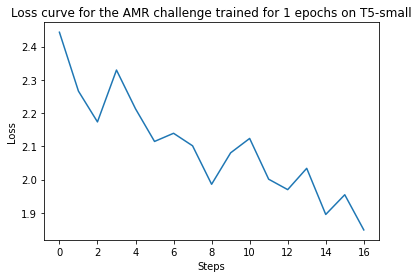

In [32]:
# Train T5 small on a mixture of all three challenges

model_t5_small = trainer(model=model_t5_small, 
                         num_batches=number_of_batches_train_amr, 
                         inputs=inputs_train_amr, 
                         labels=labels_train_amr,
                         optimizer=optimizer_t5,
                         challenge_name='AMR',
                         model_name='small')

In [ ]:
#@title Flush memory after interrupting training
#@markdown This will *hopefully* prevent a CUDA out-of-memory error.
try:
  del input_ids
except Exception:
  pass
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

## Evaluate a Model

In [65]:
# use this method to generate text for each test input ids, then save the predictions
# in a file 'hypothesis' for web nlg and amr to later use the official evaluation script for the 
# challenges
def make_predictions(model, inputs_test, tokenizer, challenge_name):

  model_predictions = []
  model.eval()
  with torch.no_grad():
    for i in range(len(inputs_test)):
      print(i)
      output = tokenizer.batch_decode(model.generate(inputs_test[i],
                                                     do_sample=True, 
                                                     max_length=400,
                                                     top_p=0.92,
                                                     top_k=0),
                                      skip_special_tokens=True)
      model_predictions.append([x.replace('<pad>','').replace('</s>','').strip() for x in output])

    # flatten the predictions list which has the length of batch_size * number_of_batches
    model_predictions = list(chain(*model_predictions))  
  model.train()
  with open('drive/MyDrive/MIwDL/data/' + challenge_name + '/test/prompt_tuning_hypothesis/hypothesis', 'w') as file:
    for i in range(len(model_predictions)):
      file.write(model_predictions[i] + '\n' if i < len(model_predictions)-1 else model_predictions[i])
  return model_predictions

In [66]:
model_predictions = make_predictions(model=model_t5_small,
                         inputs_test=inputs_test_amr,
                         tokenizer=tokenizer_t5_small,
                         challenge_name='amr')

0


TypeError: ignored

## Save the Model

In [ ]:
torch.save(model_t5_small_web_nlg.state_dict(),f'drive/MyDrive/MIwDL/models/25_epochs_t5_small/t5_small_web_nlg_{epochs}_epochs_batch_size_{batch_size_web_nlg}_optimized_inputs.bin')

In [ ]:
torch.save(model_t5_small_e2e.state_dict(),f'drive/MyDrive/MIwDL/models/25_epochs_t5_small/t5_small_e2e_{epochs}_epochs_batch_size_{batch_size_e2e}.bin')

In [ ]:
torch.save(model_t5_base_amr.state_dict(),f'drive/MyDrive/MIwDL/models/t5_base/t5_base_amr_{epochs}_epochs_batch_size_{batch_size_amr}.bin')

## Load a model

In [ ]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json
#!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
#!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-large-config.json

model_t5_small_e2e = T5ForConditionalGeneration.from_pretrained('drive/MyDrive/MIwDL/models/25_epochs_t5_small/t5_small_web_nlg_25_epochs_batch_size_8.bin', 
                                                                    return_dict=True,
                                                                    config='t5-small-config.json')

if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

model_t5_small_e2e.to(dev)

tokenizer_t5_small = T5Tokenizer.from_pretrained('t5-small')
